In [1]:
import numpy as np
import subprocess

from astropy.io import fits
from astropy.table import Table
import astropy.units as u

from glob import glob

import matplotlib

%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
import imexam

In [2]:
def hotpants(silent=False, **options):
    """
    I want to run hotpants from jupyter so I can document my process, 
    this function wraps the external function call.
    """
    
    cmd = ["hotpants"]
    
    for opt in options:
        cmd.append("-" + opt) 
        if not options[opt] is True:
            cmd.append(str(options[opt]))
        
    if not silent:
        print(' '.join(cmd))
        
    output = subprocess.run(cmd,stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    
    #return output.stdout.decode('utf-8'), output.stderr.decode('utf-8')
    if not silent:
        print(output.stderr.decode('utf-8'))
        print(output.stdout.decode('utf-8'))
    

In [4]:
def ds9_setup(xpa):
    """Set up a ds9 session. DS9 must already be running."""
    
    ds9viewer=imexam.connect(xpa)
    ds9viewer.scale("log")
    ds9viewer.scale("minmax")
    
    return ds9viewer

### Just starting with a list of all the aligned images and the templates

In [3]:
data_dir = "../data/NGC1866_images/"

In [68]:
template_files = {"I" : data_dir + "i_mean_template_crr.fits",
                 "V" :  data_dir + "v_mean_template_crr.fits"}

In [5]:
fits_files = glob(data_dir + "*aligned.fits")

In [6]:
aligned_files = {"I":[],"V":[]}

for fle in fits_files:
    band = fits.getheader(fle)['FILTER']
    aligned_files[band].append(fle)

I didn't keep track of the gain and readnoise of the images that went into the template or calculate the gain and readnoise for the templates so I am going to fix that now.

In [32]:
v_template_gain = 0
v_template_rdnoise = 0
for fle in [aligned_files['V'][i] for i in [3,13,15,16,18,30]]:
    v_template_gain += fits.getval(fle, 'GAIN', 0)
    v_template_rdnoise += fits.getval(fle, 'RDNOISE', 0)
    
v_template_gain /= 6
v_template_rdnoise /= 6

# Because image stacking reduces readnoise we need to divide out another sqrt(num imgs)
v_template_rdnoise /= np.sqrt(6)

In [13]:
i_template_gain = 0
i_template_rdnoise = 0
for fle in [aligned_files['I'][i] for i in [6,14,20,22,25,26]]:
    i_template_gain += fits.getval(fle, 'GAIN', 0)
    i_template_rdnoise += fits.getval(fle, 'RDNOISE', 0)
    
i_template_gain /= 7
i_template_rdnoise /= 7

# Because image stacking reduces readnoise we need to divide out another sqrt(num imgs)
i_template_rdnoise /= np.sqrt(7)

### I'll start with one good V-Band image as proof of concept

In [23]:
ds9viewer = ds9_setup('c0a80121:50959')

In [13]:
test_file = aligned_files["V"][0]

In [14]:
test_header = fits.getheader(test_file)
gain = test_header['GAIN']
rdnoise = test_header['RDNOISE']

In [17]:
ds9viewer.load_fits(test_file)

[-tu tuthresh]    : upper valid data count, template (25000)
[-tl tlthresh]    : lower valid data count, template (0)

[-iu iuthresh]    : upper valid data count, image (25000)
[-il ilthresh]    : lower valid data count, image (0)

[-tg tgain]       : gain in template (1)
[-tr trdnoise]    : e- readnoise in template (0)

[-ig igain]       : gain in image (1)
[-ir irdnoise]    : e- readnoise in image (0)

In [19]:
outfile = test_file.replace(".fits",".sub.fits")
hotpants(inim=test_file, tmplim=template_files['V'], outim=outfile, silent=True,
         tu=3000, tl=0, iu=3000, il=0, tg=v_template_gain, tr=v_template_rdnoise, ig=gain, ir=rdnoise)

### Now doing all the V-band images in a loop

In [121]:
subtract_image(template_files['V'], v_template_rdnoise, v_template_gain, 0, 3000, aligned_files["V"][32], silent=True)

-13.9390098412 234.187245016


### And, now, I-band

In [223]:
def subtract_image(template, t_readnoise, t_gain, tl, tu, img_file, silent=True):

    header = fits.getheader(img_file)
    gain = header['GAIN']
    rdnoise = header['RDNOISE']
    
    data = fits.getdata(img_file, 0)
    dmin = np.nanmin(data)
    dmax = np.nanmax(data)
    
    print(dmin,dmax)
    
    outfile = img_file.replace(".fits",".sub_new.fits")
    
    hotpants(inim=img_file, tmplim=template, outim=outfile, silent=silent,
             tu=tu, tl=tl, iu=dmax, il=dmin, tg=t_gain, tr=t_readnoise, ig=gain, ir=rdnoise)#,c='i')#, convvar=True)
    
    return outfile

In [259]:
outfile = subtract_image(template_files['I'], i_template_rdnoise, i_template_gain, 
                         0, 9000, aligned_files["I"][29], silent=True)

74.367857667 7179.18091037


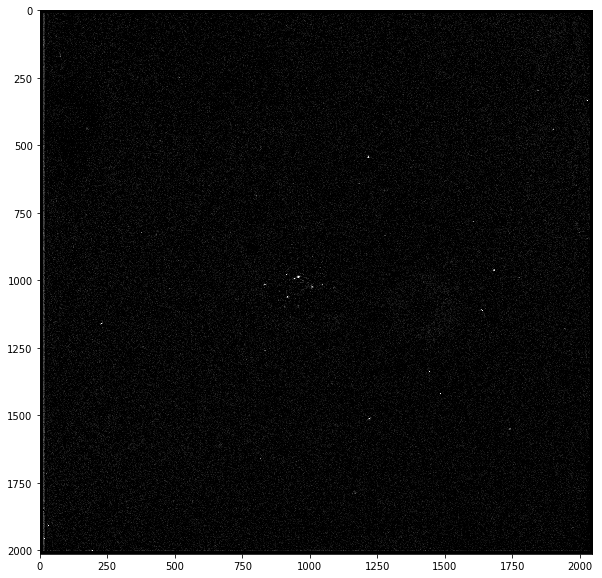

In [260]:
img = fits.getdata(outfile)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.imshow(img, cmap='gray',vmin=0,vmax=40)

In [236]:
rm ../data/NGC1866_images/coj2m002-fs01-20151023-0131-e90_aligned.sub_new.fits

2,9,11(hangs),15,18,27

In [235]:
outfile

'../data/NGC1866_images/coj2m002-fs01-20151023-0131-e90_aligned.sub_new.fits'

/Users/cbrasseur/anaconda/envs/astroconda/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


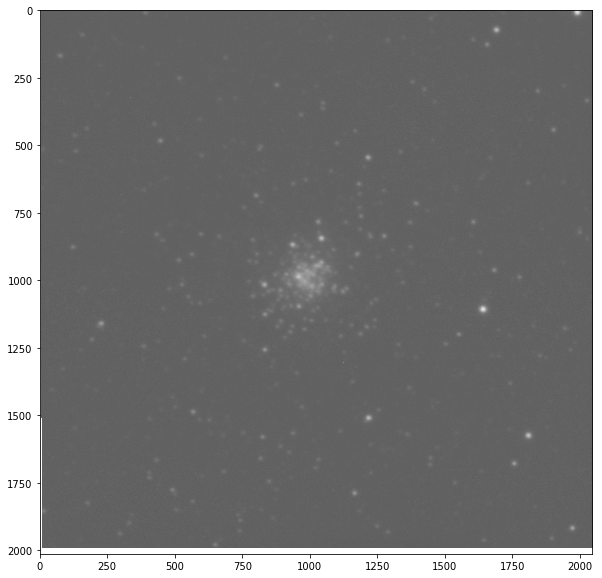

In [234]:
img = fits.getdata(aligned_files["I"][27])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

norm = LogNorm(vmin=10,vmax=3000)
ax.imshow(img, cmap='gray', norm=norm)

In [59]:
def bi_color_plot(r_img, b_img, divisor=1):
    """Showing two images in red/blue for alignment checks."""
    
    rgb = np.dstack((r_img,np.zeros(r_img.shape),b_img))
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    ax.imshow(rgb/divisor)

In [106]:
template_img = fits.getdata(template_files["I"])
aligned_img = fits.getdata(aligned_files["I"][2])
v_templ = fits.getdata(template_files["V"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


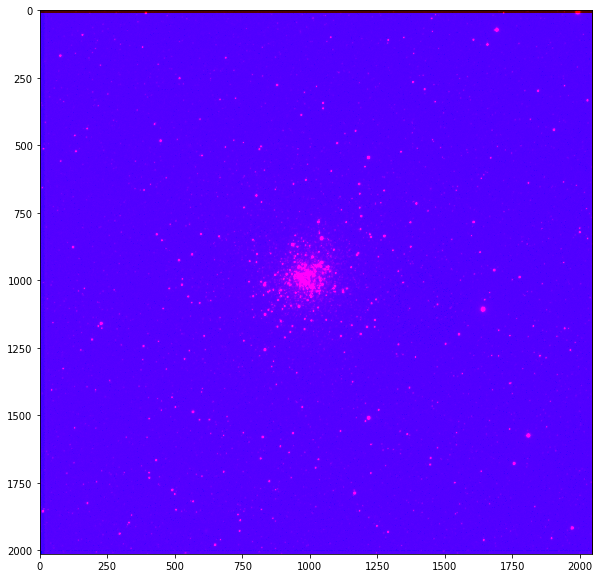

In [107]:
bi_color_plot(template_img/150,aligned_img/200)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


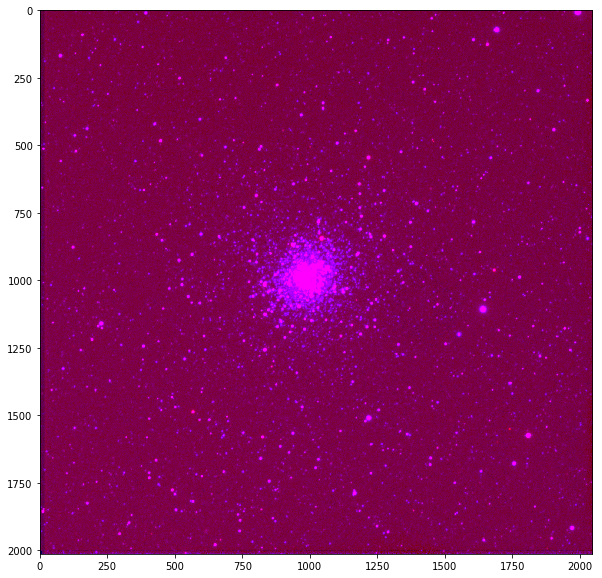

In [77]:
bi_color_plot(template_img/100,v_templ/10)

In [61]:
img_file = [x for x in aligned_files["I"] if "20160117-0092" in x][0]
img_file

'../data/NGC1866_images/coj2m002-fs01-20160117-0092-e90_aligned.fits'

In [64]:
img_file = aligned_files["I"][5]

In [67]:
header = fits.getheader(img_file)
gain = header['GAIN']
rdnoise = header['RDNOISE']

print(gain, rdnoise)
    
data = fits.getdata(img_file, 0)
dmin = np.nanmin(data)
dmax = np.nanmax(data)

print(dmin,dmax)
    
outfile = img_file.replace(".fits",".sub.fits")
hotpants(inim=img_file, tmplim=template_files['I'], outim=outfile, silent=False,
         tu=9000, tl=0, iu=dmax, il=dmin, tg=i_template_gain, tr=i_template_rdnoise, ig=gain, ir=rdnoise,
         ng="3 6 0.75 4 1.55 2 3.05", r=8)#, c='i', r=8)

8.14 11.18
35.3637695232 4507.51413249
hotpants -inim ../data/NGC1866_images/coj2m002-fs01-20151102-0103-e90_aligned.fits -tmplim ../data/NGC1866_images/i_mean_template_crr.fits -outim ../data/NGC1866_images/coj2m002-fs01-20151102-0103-e90_aligned.sub.fits -tu 9000 -tl 0 -iu 4507.51413249 -il 35.3637695232 -tg 8.14 -tr 4.22564280824 -ig 8.14 -ir 11.18 -ng 3 6 0.75 4 1.55 2 3.05 -r 8




In [63]:
ds9viewer.load_fits(outfile)

In [144]:
for i in [5,7,9,10,12,28]:
    print(aligned_files["I"][i])

../data/NGC1866_images/coj2m002-fs01-20151102-0103-e90_aligned.fits
../data/NGC1866_images/coj2m002-fs01-20151209-0093-e90_aligned.fits
../data/NGC1866_images/coj2m002-fs01-20151219-0089-e90_aligned.fits
../data/NGC1866_images/coj2m002-fs01-20151227-0067-e90_aligned.fits
../data/NGC1866_images/coj2m002-fs01-20151231-0094-e90_aligned.fits
../data/NGC1866_images/coj2m002-fs01-20160209-0096-e90_aligned.fits


In [159]:
img_file = aligned_files["I"][5]


header = fits.getheader(img_file)
gain = header['GAIN']
rdnoise = header['RDNOISE']

print(gain, rdnoise)
    
data = fits.getdata(img_file, 0)
dmin = np.nanmin(data)
dmax = np.nanmax(data)

print(dmin,dmax)
    
outfile = img_file.replace(".fits",".sub.fits")
hotpants(inim=img_file, tmplim=template_files['I'], outim=outfile, silent=False,
         tu=9000, tl=0, iu=dmax, il=dmin, tg=i_template_gain, tr=i_template_rdnoise, ig=gain, ir=rdnoise,
         ng="3 6 0.75 4 1.55 2 3.05")

8.14 11.18
35.3637695232 4507.51413249
hotpants -inim ../data/NGC1866_images/coj2m002-fs01-20151102-0103-e90_aligned.fits -tmplim ../data/NGC1866_images/i_mean_template_crr.fits -outim ../data/NGC1866_images/coj2m002-fs01-20151102-0103-e90_aligned.sub.fits -tu 9000 -tl 0 -iu 4507.51413249 -il 35.3637695232 -tg 8.14 -tr 4.22564280824 -ig 8.14 -ir 11.18 -ng 3 6 0.75 4 1.55 2 3.05




In [139]:
[5,7,9,10,12,28]

In [152]:
ds9viewer.load_fits(aligned_files["I"][18])

### Subtracting the aligned imaged from David

In [25]:
david_images = glob("../data/NGC1866_images/*david*")

I think these are all I-band images.

In [35]:
subtract_image(template_files['I'], i_template_rdnoise, i_template_gain, 0, 9000, david_images[6], silent=True)

0.0 9109.11816406


### Playing with the ones that still need help

In [15]:
prob_img = ['coj2m002-fs01-20160109-0129-e90_aligned',
            'coj2m002-fs01-20160117-0092-e90_aligned',   
            'coj2m002-fs01-20160126-0092-e90_aligned',
            'coj2m002-fs01-20160216-0099-e90_aligned']

In [22]:
prob_paths = [x for x in aligned_files['I'] if x[23:62] in prob_img]

In [78]:
img_file = prob_paths[3]
#img_file = '../data/NGC1866_images/coj2m002-fs01-20160117-0092-e90_david.fits'


header = fits.getheader(img_file)
gain = header['GAIN']
rdnoise = header['RDNOISE']

print(gain, rdnoise)
    
data = fits.getdata(img_file, 0)
dmin = np.nanmin(data)
dmax = np.nanmax(data)

print(dmin,dmax)
    
outfile = img_file.replace(".fits",".sub.fits")
hotpants(inim=img_file, tmplim=template_files['I'], outim=outfile, silent=False,
         tu=9000, tl=0, iu=dmax, il=dmin, tg=i_template_gain, tr=i_template_rdnoise, ig=gain, ir=rdnoise,bgo=2)#c='t')
         #ng="3 6 0.75 4 1.55 2 3.05")

8.14 11.18
44.295417891 15368.7400356
hotpants -inim ../data/NGC1866_images/coj2m002-fs01-20160216-0099-e90_aligned.fits -tmplim ../data/NGC1866_images/i_mean_template_crr.fits -outim ../data/NGC1866_images/coj2m002-fs01-20160216-0099-e90_aligned.sub.fits -tu 9000 -tl 0 -iu 15368.7400356 -il 44.295417891 -tg 8.14 -tr 4.22564280824 -ig 8.14 -ir 11.18 -bgo 2
Doing : ../data/NGC1866_images/coj2m002-fs01-20160216-0099-e90_aligned.fits -
        ../data/NGC1866_images/i_mean_template_crr.fits =
        ../data/NGC1866_images/coj2m002-fs01-20160216-0099-e90_aligned.sub.fits
   Good templ data : 0.0 -> 9000.0
   Good image data : 44.3 -> 15368.7
Mallocing massive amounts of memory...
Region 0 pixels            : 1:2045,1:2013
 Vector Indices (buffered) : 0:2044,0:2012
 Vector Indices (good data): 0:2044,0:2012
Build stamp  : t    0 i    0 (grid coord  0  0)
    Stamp in region : 0:178,0:178
    Tmpl  xs :   89 ys :   89  (sky,dsky = 36.1,1.0)
    Image xs :   89 ys :   89  (sky,dsky = 57.0,2.

In [79]:
ds9viewer.load_fits(prob_paths[3].replace('.fits','.sub.fits'))

In [56]:
ls ../data/NGC1866_images/coj2m002-fs01-20160216-0099-e90*

../data/NGC1866_images/coj2m002-fs01-20160216-0099-e90.fits
../data/NGC1866_images/coj2m002-fs01-20160216-0099-e90_aligned.fits
../data/NGC1866_images/coj2m002-fs01-20160216-0099-e90_aligned.sub.fits


In [80]:
[x.replace('.fits','.sub.fits') for x in prob_paths]

['../data/NGC1866_images/coj2m002-fs01-20160109-0129-e90_aligned.sub.fits',
 '../data/NGC1866_images/coj2m002-fs01-20160117-0092-e90_aligned.sub.fits',
 '../data/NGC1866_images/coj2m002-fs01-20160126-0092-e90_aligned.sub.fits',
 '../data/NGC1866_images/coj2m002-fs01-20160216-0099-e90_aligned.sub.fits']

In [81]:
cd ../data/NGC1866_images/

/Users/cbrasseur/Documents/ljmu/CepheidVariables/data/NGC1866_images
